<a href="https://colab.research.google.com/github/mbk-dev/publications_RUS/blob/main/15%20compare_CAGR_of_assets_2024.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

Статья [Сравнение доходности активов за 2024 год](https://rostsber.ru/publish/stocks/returns2024.html) на блоге "Рост Сбережений"

In [1]:
#!pip install okama

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12.0, 6.0]

import okama as ok

ok.__version__

'1.4.4'

## Активы

### 2003 для 20+ лет

In [3]:
ls_2003 = [
    'RGBITR.INDX',
    'RUCBTRNS.INDX',
    'MCFTR.INDX',
    'SP500TR.INDX',
    # 'IDCOTCTR.INDX',  # US Treasuries
    'SP500BDT.INDX',  # US bonds
    'FNER.INDX',  # REITS
    'MOW_SEC.RE',
    'GC.COMM',
    'SI.COMM',
    'USDRUB.FX',
    'EURRUB.FX',
    'CNYRUB.FX'
]
len(ls_2003)

12

In [4]:
lg_2003 = {
    'RGBITR.INDX': 'Облигации федерального займа РФ (Индекс RGBI)',
    'RUCBTRNS.INDX': 'Корпоративные облигации РФ (индекс RUCBTRNS)',
    'MCFTR.INDX': 'Акции РФ (Индекс Мосбиржи)',
    'SP500TR.INDX': 'Акции США (Индекс S&P 500)',
    # 'IDCOTCTR.INDX': 'Казначейские облигации США (Индекс ICE U.S Treasury Core Bond)',
    'SP500BDT.INDX': 'Корпоративные облигации США (Индекс S&P 500 bonds)',
    'FNER.INDX': 'Недвижимость США (Индекс REIT)',
    'MOW_SEC.RE': 'Недвижимость Москвы (цена кв. метра)',  # раз в квартал 
    'GC.COMM': 'Золото (цены спот)',
    'SI.COMM': 'Серебро (цены спот)',
    'USDRUB.FX': 'Доллар США',
    'EURRUB.FX': 'Евро',
    'CNYRUB.FX': 'Юань',
    'RUB.INFL': 'Инфляция',
}
len(lg_2003)

13

### 2010 для 15+ лет

In [30]:
ls_2010 = ls_2003 + [
    'OKID10.INDX',  # c 2010 года
    'OKID.INDX',  # c 2010 года
    'RUONIA.INDX',  # c 2010-02
    'BTC-USD.CC'
]

In [31]:
lg_2010 = {**lg_2003, **{
    'OKID10.INDX': 'Депозиты в рублях TOP10 (индекс OKID 10)',
    'OKID.INDX': 'Депозиты в рублях (индекс OKID)',
    'RUONIA.INDX': 'Денежные фонды (индекс RUSFAR)',
    'BTC-USD.CC': 'Биткоин (BTC)'
}}

### Короткая история

In [32]:
ls_2020 = ls_2010 + [
    'MREDC.INDX',  # c 2010 года
]

In [33]:
lg_2020 = {**lg_2010, **{
    'MREDC.INDX': 'Недвижимость Москвы (индекс MREDC)',
}}

In [34]:
ls_2020

['RGBITR.INDX',
 'RUCBTRNS.INDX',
 'MCFTR.INDX',
 'SP500TR.INDX',
 'SP500BDT.INDX',
 'FNER.INDX',
 'MOW_SEC.RE',
 'GC.COMM',
 'SI.COMM',
 'USDRUB.FX',
 'EURRUB.FX',
 'CNYRUB.FX',
 'OKID10.INDX',
 'OKID.INDX',
 'RUONIA.INDX',
 'MREDC.INDX']

## Функция рисования графиков

In [63]:
def plot_cagr(assets: ok.AssetList, legend_dic: dict, plot_title: str):
    fig, ax = plt.subplots(figsize=[12.0, 10.0])
    fig.subplots_adjust(right=1.2)

    inflation = assets.get_cagr().at['RUB.INFL'] * 100
    names = assets.get_cagr().sort_values().index
    width = 0.7  # ширина прямоугольники (в данном случае высота)

    for name in names:
        value = assets.get_cagr().loc[name] * 100
        color = 'grey' if name == 'RUB.INFL' else 'green'
        if 0 <= value < inflation:
            color = 'yellow'
        elif value < 0:
            color = 'red'
        ax.barh(name, value, width, color=color)

    ax.axvline(x=assets.get_cagr().loc["USDRUB.FX"] * 100, linestyle="--")


    # Добавление титула и надписей на оси Y
    x = np.arange(len(names))  # the label locations
    ax.set_title(plot_title)
    ax.set_yticks(x)
    ax.set_yticklabels([legend_dic[x] for x in names])
    # ax.legend()

    # Добавление аннотаций к прямоугольникам
    rects = ax.containers
    for rect in rects:
        width = rect[0].get_width()  # Ширина прямоугольника
        shift = 20 if width >= 0 else -20
        ax.annotate(f'{width:.2f}%',
                    xy=(width, rect[0].get_y() + rect[0].get_height() / 2),
                    # координаты точки, откуда начинается аннотация
                    xytext=(shift, 0),  # смещение надписи вправо
                    textcoords="offset points",
                    ha='center', va='center')
    if any(assets.get_cagr().values < 0):
        ax.axvline(x=0, color='black', linewidth=1)  # вертикальная линия на отметке х=0

In [99]:
def plot_rolling_cagr(assets_dict: dict, ccy: str, window: int, real: bool, chart: str = "cagr"):
    assets_tickers = assets_dict.keys()
    real = real if chart == "cagr" else False
    al = ok.AssetList(assets_tickers, ccy=ccy, inflation=real)
    df = al.get_rolling_cagr(window=window, real=True) * 100 if chart == "cagr" else al.get_rolling_risk_annual(window=window) * 100
    max_value = df.to_numpy().max()
    min_value = df.to_numpy().min()
    
    # plot
    fig = plt.figure(figsize=(12,6))
    # fig.subplots_adjust(bottom=0.2, top=1.5)
    ax = plt.gca()
    first_date_dt = df.index[0]
    print(f'{first_date_dt=}')
    last_date_dt = pd.to_datetime('2024-12')
    
    colors = ["blue", "red", "green", "yellow", "black"]

    for asset, color in zip(assets_dict.items(), colors):
        ticker = asset[0]
        description = asset[1]
        ax.plot(df.index.to_timestamp(), df[ticker], label=description, color=color)

    # Spines : https://matplotlib.org/stable/gallery/ticks_and_spines/spine_placement_demo.html
    # ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    # ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xlim(first_date_dt, last_date_dt)

    if chart == "cagr":
        min_value = min_value * 1.05 if min_value < 0 else min_value * 0.95
    elif chart == "risk":
        min_value = 0
    
    ax.set_ylim(min_value, max_value)
    ax.set_xlim(first_date_dt, last_date_dt + pd.DateOffset(months=1))
    leg = ax.legend(loc='upper left')
    # Создаём сетку на графике
    # ax.grid(which='major', linewidth=1.2, linestyle='--', color='blue')

## 20 лет

In [11]:
assets20 = ok.AssetList(ls_2003, first_date='2005-01', last_date='2024-12', inflation=True, ccy='RUB')
assets20

assets           [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2005-01
last_date                                                  2024-12
period_length                                   20 years, 0 months
inflation                                                 RUB.INFL
dtype: object

In [11]:
assets20.assets_first_dates

{'SI.COMM': Timestamp('1970-03-01 00:00:00'),
 'FNER.INDX': Timestamp('1972-01-01 00:00:00'),
 'GC.COMM': Timestamp('1975-02-01 00:00:00'),
 'SP500TR.INDX': Timestamp('1988-02-01 00:00:00'),
 'USDRUB.FX': Timestamp('1992-08-01 00:00:00'),
 'CNYRUB.FX': Timestamp('1992-08-01 00:00:00'),
 'RUB': Timestamp('1992-08-01 00:00:00'),
 'SP500BDT.INDX': Timestamp('1995-01-01 00:00:00'),
 'MCFTR.INDX': Timestamp('1997-10-01 00:00:00'),
 'EURRUB.FX': Timestamp('1999-02-01 00:00:00'),
 'MOW_SEC.RE': Timestamp('2000-04-01 00:00:00'),
 'RGBITR.INDX': Timestamp('2003-01-01 00:00:00'),
 'RUCBTRNS.INDX': Timestamp('2003-01-01 00:00:00'),
 'RUB.INFL': Timestamp('1991-01-01 00:00:00')}

In [12]:
assets20.assets_last_dates

{'FNER.INDX': Timestamp('2024-11-01 00:00:00'),
 'MOW_SEC.RE': Timestamp('2024-12-01 00:00:00'),
 'RGBITR.INDX': Timestamp('2025-01-01 00:00:00'),
 'RUCBTRNS.INDX': Timestamp('2025-01-01 00:00:00'),
 'MCFTR.INDX': Timestamp('2025-01-01 00:00:00'),
 'SP500TR.INDX': Timestamp('2025-01-01 00:00:00'),
 'SP500BDT.INDX': Timestamp('2025-01-01 00:00:00'),
 'GC.COMM': Timestamp('2025-01-01 00:00:00'),
 'SI.COMM': Timestamp('2025-01-01 00:00:00'),
 'USDRUB.FX': Timestamp('2025-01-01 00:00:00'),
 'EURRUB.FX': Timestamp('2025-01-01 00:00:00'),
 'CNYRUB.FX': Timestamp('2025-01-01 00:00:00'),
 'RUB': Timestamp('2025-01-01 00:00:00'),
 'RUB.INFL': Timestamp('2024-12-01 00:00:00')}

Text(0.5, 1.0, 'Накопленный доход за 20 лет')

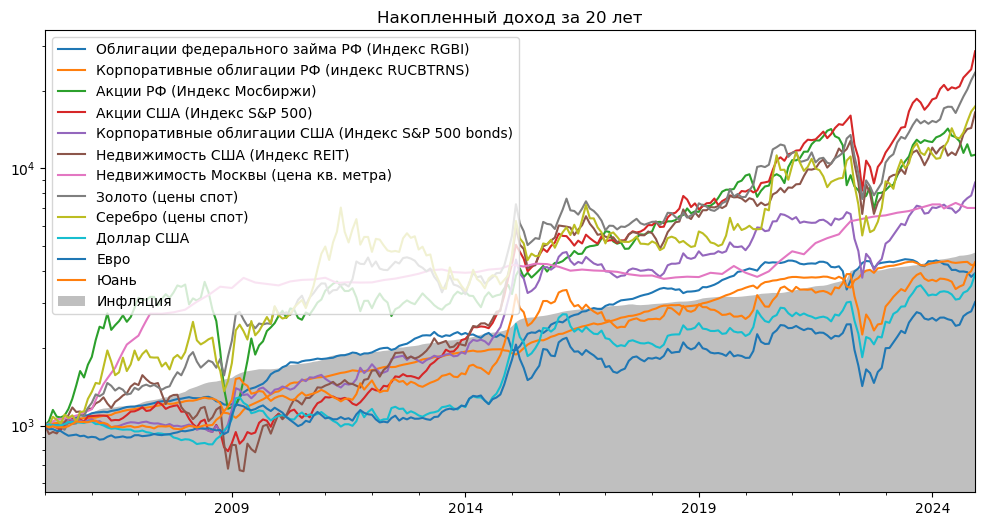

In [35]:
assets20.wealth_indexes.iloc[:, :-1].plot(logy=True)
plt.fill_between(assets20.wealth_indexes.index.to_timestamp(), 0, assets20.wealth_indexes['RUB.INFL'], facecolor='grey', alpha=0.5)
plt.legend(lg_2003.values())
plt.xlabel("")
plt.title('Накопленный доход за 20 лет')

In [45]:
assets20.describe([1, 5, 10, 20])

,property,period,RGBITR.INDX,RUCBTRNS.INDX,MCFTR.INDX,SP500TR.INDX,SP500BDT.INDX,FNER.INDX,MOW_SEC.RE,GC.COMM,SI.COMM,USDRUB.FX,EURRUB.FX,CNYRUB.FX,inflation
0,Compound return,YTD,-0.020941,0.041457,0.01628,0.417418,0.15947,0.189467,-0.03131,0.443979,0.365375,0.133505,0.069653,0.067751,0.095136
1,CAGR,1 years,-0.020941,0.041457,0.01628,0.417418,0.15947,0.189467,-0.03131,0.443979,0.365375,0.133505,0.069653,0.067751,0.095136
2,CAGR,5 years,0.010901,0.05365,0.065288,0.264759,0.112061,0.140614,0.122968,0.233088,0.215407,0.104267,0.088761,0.086779,0.08407
3,CAGR,10 years,0.080585,0.088437,0.147684,0.200095,0.088182,0.122766,0.052131,0.149485,0.128622,0.060952,0.044907,0.040098,0.069734
4,CAGR,20 years,0.075148,0.077643,0.136279,0.177626,0.110801,0.142431,0.102347,0.167394,0.14691,0.067086,0.052921,0.070966,0.08124
5,CAGR,"20 years, 0 months",0.075148,0.077643,0.136279,0.177626,0.110801,0.142431,0.102347,0.167394,0.14691,0.067086,0.052921,0.070966,0.08124
6,Annualized mean return,"20 years, 0 months",0.078709,0.078902,0.172595,0.200992,0.128966,0.181121,0.104472,0.199007,0.212451,0.08272,0.067609,0.086679,NaN
7,Dividend yield,LTM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8,Risk,"20 years, 0 months",0.087077,0.051984,0.290885,0.238909,0.206636,0.307344,0.069442,0.283271,0.418458,0.188115,0.179717,0.187933,NaN
9,CVAR,"20 years, 0 months",0.161545,0.125852,0.644897,0.338278,0.347368,0.395392,0.056978,0.257367,0.400735,0.244153,0.341637,0.293521,NaN


In [46]:
assets20.describe([1, 5, 10, 20]).to_csv("20years.csv")

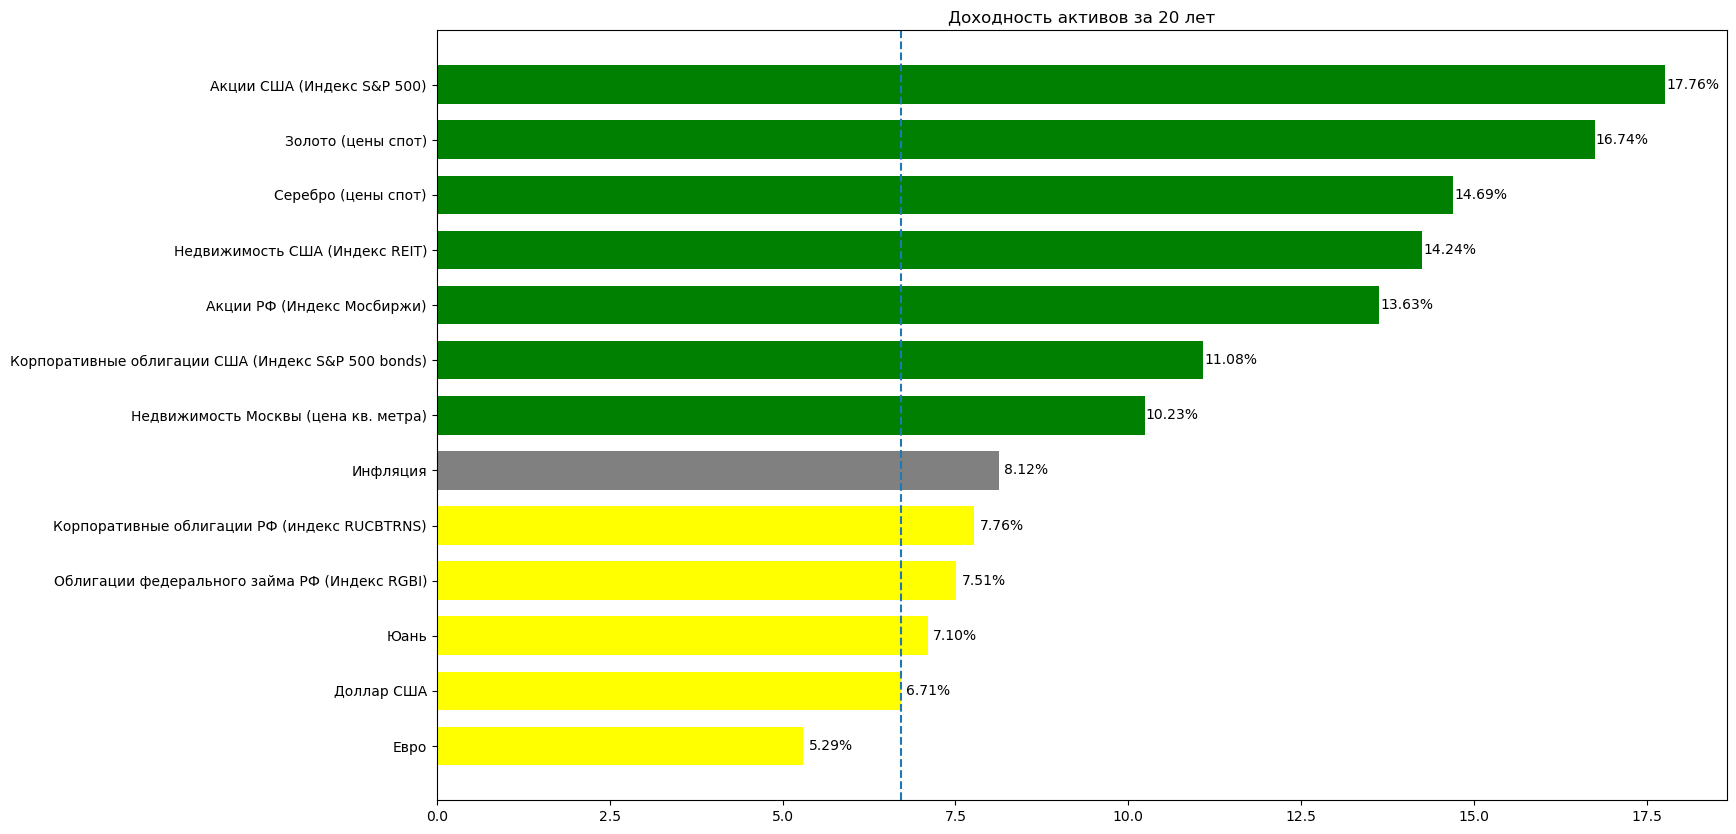

In [14]:
plot_cagr(assets20, lg_2003, 'Доходность активов за 20 лет')

## 10 лет

In [18]:
assets10 = ok.AssetList(ls_2010, first_date='2015-01', last_date='2024-12', ccy='RUB')
assets10

assets           [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2015-01
last_date                                                  2024-12
period_length                                   10 years, 0 months
inflation                                                 RUB.INFL
dtype: object

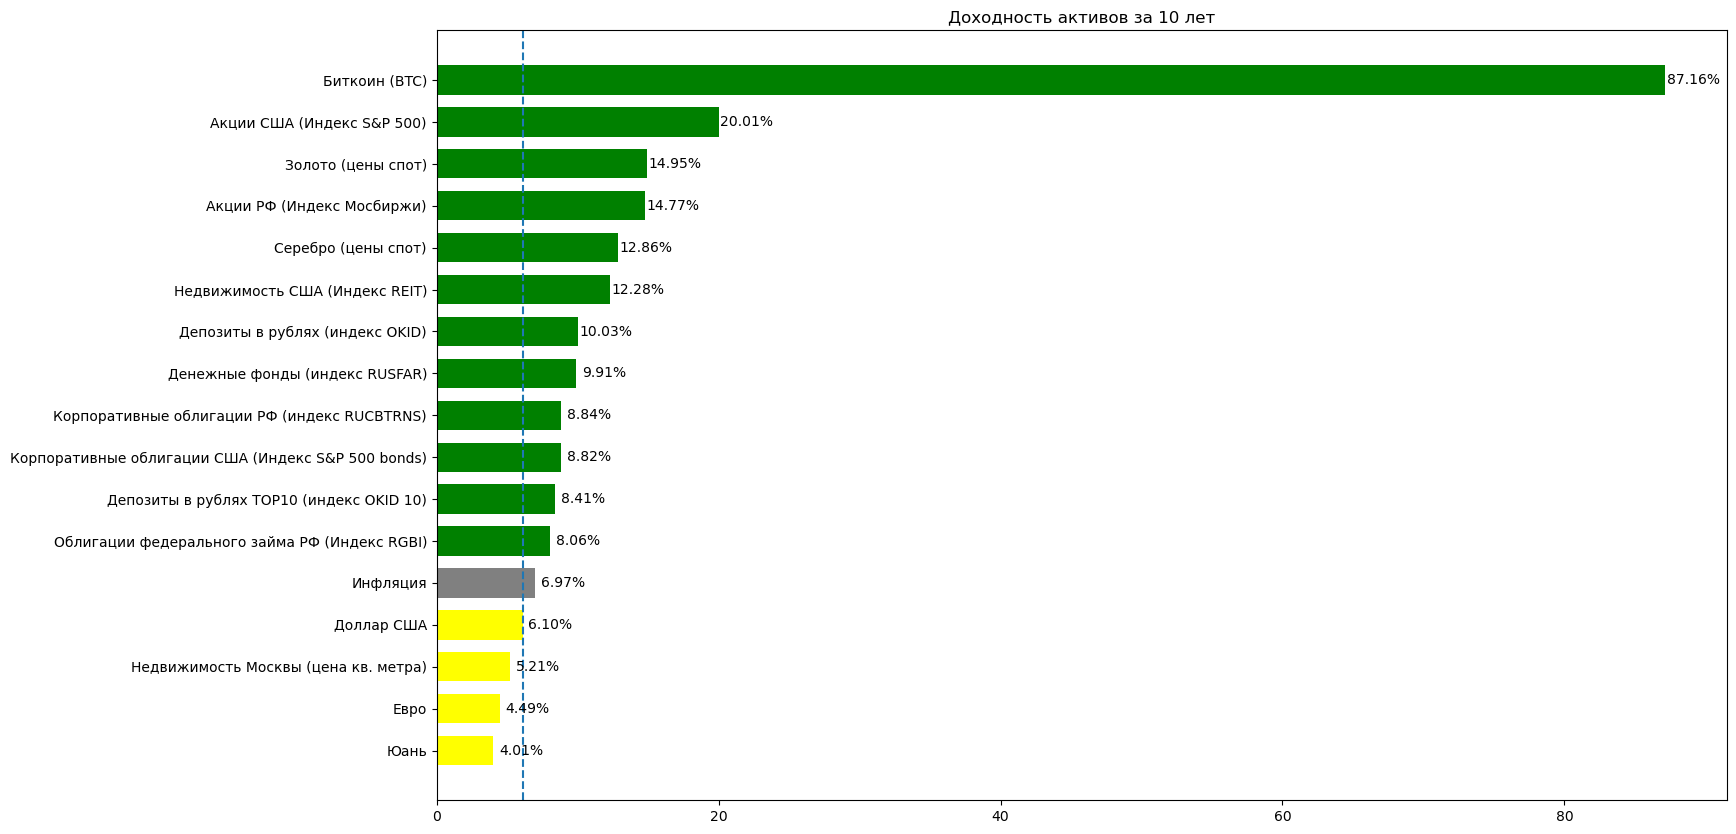

In [19]:
plot_cagr(assets10, lg_2010, 'Доходность активов за 10 лет')

## 5 лет

In [25]:
assets5 = ok.AssetList(ls_2020, first_date='2020-01', last_date='2024-12', ccy='RUB')
assets5

assets           [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2020-01
last_date                                                  2024-12
period_length                                    5 years, 0 months
inflation                                                 RUB.INFL
dtype: object

In [67]:
assets5.assets_first_dates

{'SI.COMM': Timestamp('1970-03-01 00:00:00'),
 'FNER.INDX': Timestamp('1972-01-01 00:00:00'),
 'GC.COMM': Timestamp('1975-02-01 00:00:00'),
 'SP500TR.INDX': Timestamp('1988-02-01 00:00:00'),
 'USDRUB.FX': Timestamp('1992-08-01 00:00:00'),
 'CNYRUB.FX': Timestamp('1992-08-01 00:00:00'),
 'RUB': Timestamp('1992-08-01 00:00:00'),
 'SP500BDT.INDX': Timestamp('1995-01-01 00:00:00'),
 'MCFTR.INDX': Timestamp('1997-10-01 00:00:00'),
 'EURRUB.FX': Timestamp('1999-02-01 00:00:00'),
 'MOW_SEC.RE': Timestamp('2000-04-01 00:00:00'),
 'RGBITR.INDX': Timestamp('2003-01-01 00:00:00'),
 'RUCBTRNS.INDX': Timestamp('2003-01-01 00:00:00'),
 'RUONIA.INDX': Timestamp('2010-02-01 00:00:00'),
 'OKID10.INDX': Timestamp('2010-07-01 00:00:00'),
 'OKID.INDX': Timestamp('2010-07-01 00:00:00'),
 'MREDC.INDX': Timestamp('2017-01-01 00:00:00'),
 'RUB.INFL': Timestamp('1991-01-01 00:00:00')}

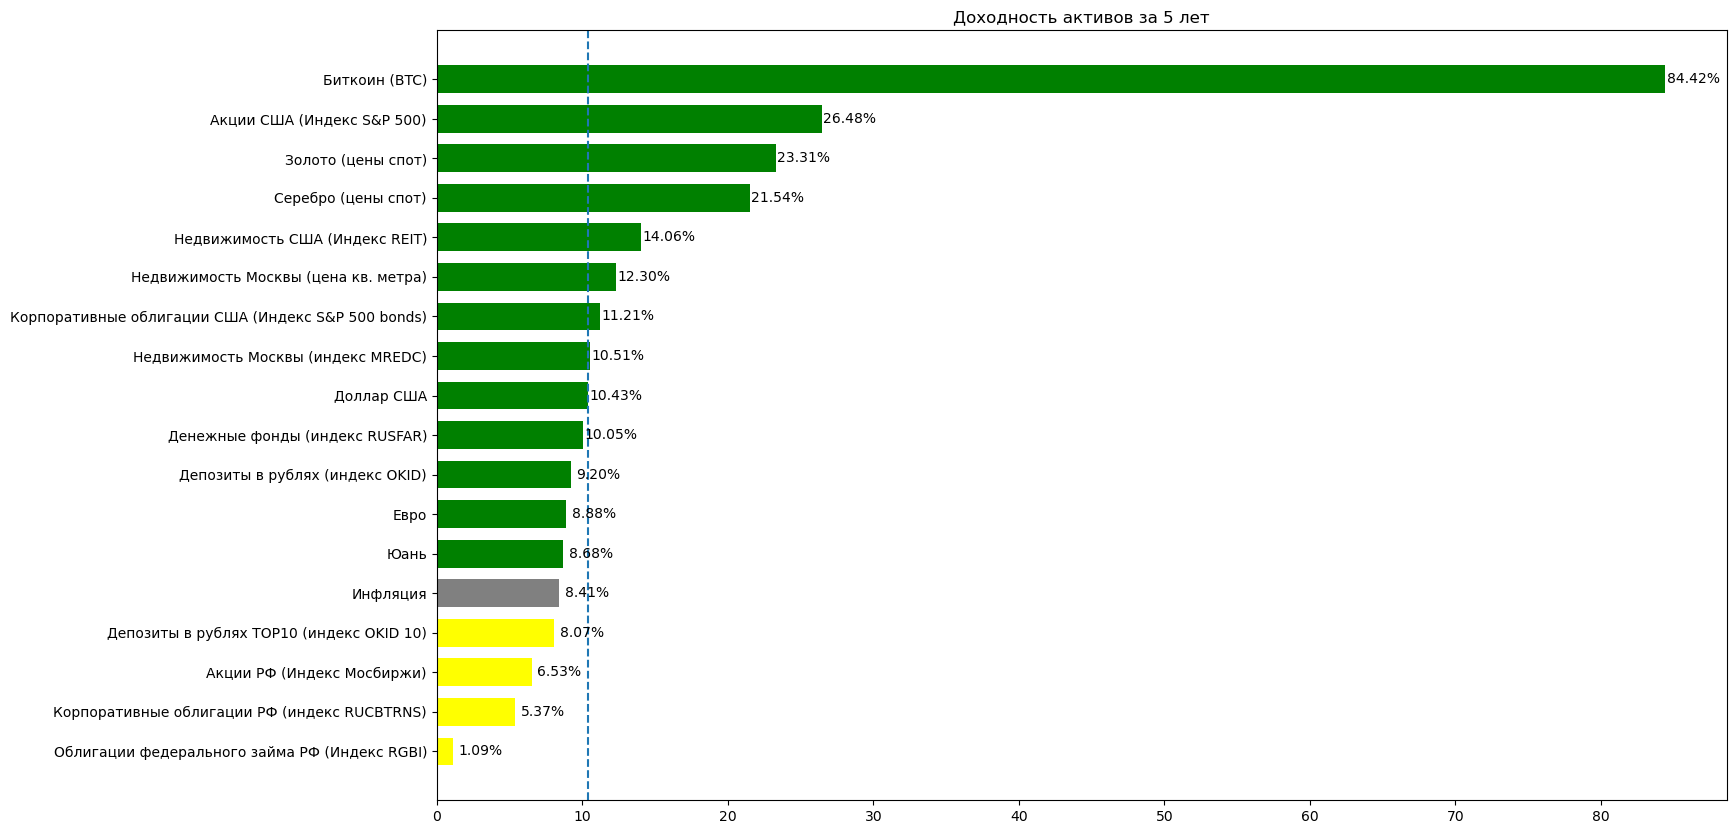

In [29]:
plot_cagr(assets5, lg_2020, 'Доходность активов за 5 лет')

In [23]:
assets5.describe([2, 3])

,property,period,RGBITR.INDX,RUCBTRNS.INDX,MCFTR.INDX,SP500TR.INDX,SP500BDT.INDX,FNER.INDX,MOW_SEC.RE,GC.COMM,SI.COMM,USDRUB.FX,EURRUB.FX,CNYRUB.FX,OKID10.INDX,OKID.INDX,inflation
0,Compound return,YTD,-0.020941,0.041457,0.01628,0.417418,0.15947,0.189467,-0.03131,0.443979,0.365375,0.133505,0.069653,0.067751,0.134641,0.141282,0.098271
1,CAGR,2 years,-0.006796,0.036635,0.250506,0.510599,0.266042,0.299446,0.033635,0.447663,0.319076,0.202152,0.184171,0.164931,0.107968,0.118511,0.086152
2,CAGR,3 years,0.007637,0.055747,-0.006342,0.209483,0.089599,0.062582,0.081801,0.254741,0.192485,0.110147,0.080633,0.048507,0.099253,0.111902,0.097067
3,CAGR,"5 years, 0 months",0.010901,0.05365,0.065288,0.264759,0.112061,0.140614,0.122968,0.233088,0.215407,0.104267,0.088761,0.086779,0.080661,0.091989,0.08469
4,Annualized mean return,"5 years, 0 months",0.018292,0.05605,0.105678,0.318109,0.14411,0.192992,0.124573,0.276764,0.306729,0.131453,0.119284,0.116338,0.080699,0.092028,NaN
5,Dividend yield,LTM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,Risk,"5 years, 0 months",0.122874,0.071906,0.297389,0.38043,0.274394,0.361452,0.060615,0.339822,0.51943,0.25311,0.266171,0.260943,0.009235,0.009282,NaN
7,CVAR,"5 years, 0 months",0.206548,0.084575,0.505114,0.368064,0.389025,0.33932,0.03131,0.279862,0.450831,0.293137,0.375313,0.313004,-0.047712,-0.057249,NaN
8,Max drawdowns,"5 years, 0 months",-0.228385,-0.09348,-0.512716,-0.48951,-0.443925,-0.480924,-0.044328,-0.436844,-0.526212,-0.39155,-0.425154,-0.418448,0.0,0.0,NaN
9,Max drawdowns dates,"5 years, 0 months",2022-02,2022-03,2022-09,2022-06,2022-06,2022-06,2024-09,2022-06,2022-06,2022-06,2022-06,2022-06,2020-01,2020-01,NaN


## 1 год

In [26]:
assets1 = ok.AssetList(ls_2020, first_date='2024-01', last_date='2024-12', ccy='RUB')
assets1

assets           [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2024-01
last_date                                                  2024-12
period_length                                    1 years, 0 months
inflation                                                 RUB.INFL
dtype: object

In [28]:
assets1.get_cagr()

RGBITR.INDX     -0.020941
RUCBTRNS.INDX    0.041457
MCFTR.INDX       0.016280
SP500TR.INDX     0.417418
SP500BDT.INDX    0.159470
FNER.INDX        0.189467
MOW_SEC.RE      -0.031310
GC.COMM          0.443979
SI.COMM          0.365375
USDRUB.FX        0.133505
EURRUB.FX        0.069653
CNYRUB.FX        0.067751
OKID10.INDX      0.134641
OKID.INDX        0.141282
RUONIA.INDX      0.188081
BTC-USD.CC       1.505482
MREDC.INDX       0.037022
RUB.INFL         0.095136
dtype: float64

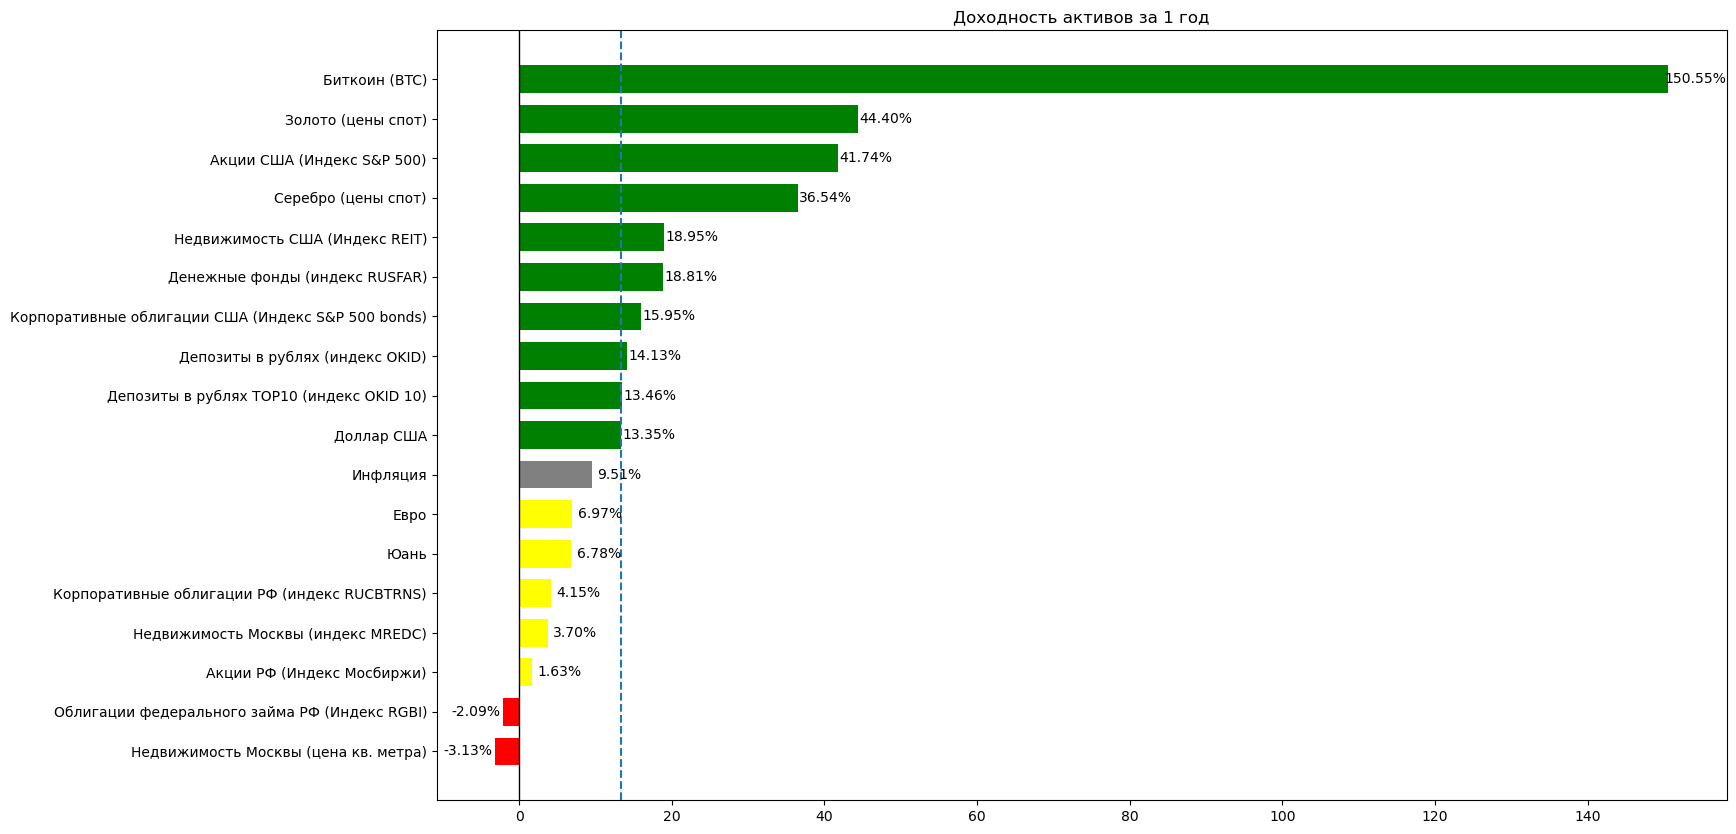

In [27]:
plot_cagr(assets1, lg_2020, 'Доходность активов за 1 год')

In [27]:
assets1.describe()

,property,period,RGBITR.INDX,RUCBTRNS.INDX,MCFTR.INDX,SP500TR.INDX,SP500BDT.INDX,FNER.INDX,MOW_SEC.RE,GC.COMM,SI.COMM,USDRUB.FX,EURRUB.FX,CNYRUB.FX,OKID10.INDX,OKID.INDX,MREDC.INDX,inflation
0,Compound return,YTD,-0.020941,0.041457,0.01628,0.417418,0.15947,0.189467,-0.03131,0.443979,0.365375,0.133505,0.069653,0.067751,0.134641,0.141282,0.037022,0.098271
1,CAGR,1 years,-0.020941,0.041457,0.01628,0.417418,0.15947,0.189467,-0.03131,0.443979,0.365375,0.133505,0.069653,0.067751,0.134641,0.141282,0.037022,0.098271
2,CAGR,5 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CAGR,10 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAGR,"1 years, 0 months",-0.020941,0.041457,0.01628,0.417418,0.15947,0.189467,-0.03131,0.443979,0.365375,0.133505,0.069653,0.067751,0.134641,0.141282,0.037022,0.098271
5,Annualized mean return,"1 years, 0 months",-0.014305,0.04365,0.044274,0.448483,0.175636,0.232733,-0.02998,0.467767,0.407727,0.146052,0.082139,0.084184,0.13466,0.141302,0.038358,NaN
6,Dividend yield,LTM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7,Risk,"1 years, 0 months",0.121765,0.071463,0.258002,0.320558,0.206979,0.347036,0.052971,0.276826,0.363403,0.17983,0.173549,0.199204,0.006809,0.006963,0.054983,NaN
8,CVAR,"1 years, 0 months",0.020941,-0.041457,-0.01628,-0.417418,-0.15947,-0.189467,0.03131,-0.443979,-0.365375,-0.133505,-0.069653,-0.067751,-0.134641,-0.141282,-0.037022,NaN
9,Max drawdowns,"1 years, 0 months",-0.137069,-0.035143,-0.21582,-0.07876,-0.072154,-0.131796,-0.044328,-0.062623,-0.109997,-0.071703,-0.0718,-0.089166,0.0,0.0,-0.029513,NaN


## Граница эффективности


In [28]:
x = ok.EfficientFrontier(ls_2003, ccy='RUB', first_date='2005-01', last_date='2024-12')
x

symbols          [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2005-01
last_date                                                  2024-12
period_length                                   20 years, 0 months
bounds           ((0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0...
inflation                                                     None
n_points                                                        20
dtype: object

In [29]:
y = ok.EfficientFrontier(ls_2003, ccy='RUB', first_date='2004-01', last_date='2023-12')
y

symbols          [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2004-01
last_date                                                  2023-12
period_length                                   20 years, 0 months
bounds           ((0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0...
inflation                                                     None
n_points                                                        20
dtype: object

In [30]:
df = x.ef_points

In [31]:
df_last_y = y.ef_points

In [32]:
short_names_2003 = {
    'RGBITR.INDX': 'ОФЗ',
    'RUCBTRNS.INDX': 'Корпоративные облигации РФ',
    'MCFTR.INDX': 'Акции РФ',
    'SP500TR.INDX': 'Акции США',
    'SP500BDT.INDX': 'Корпоративные облигации США',
    'FNER.INDX': 'REIT',
    'MOW_SEC.RE': 'Недвижимость Москвы',
    'GC.COMM': 'Золото',
    'SI.COMM': 'Серебро',
    'USDRUB.FX': 'USD',
    'EURRUB.FX': 'EUR',
    'CNYRUB.FX': 'CNY',
}

<Axes: title={'center': 'Граница эффективности - 20 лет (2005 - 2024)'}, xlabel='Риск', ylabel='Доходность'>

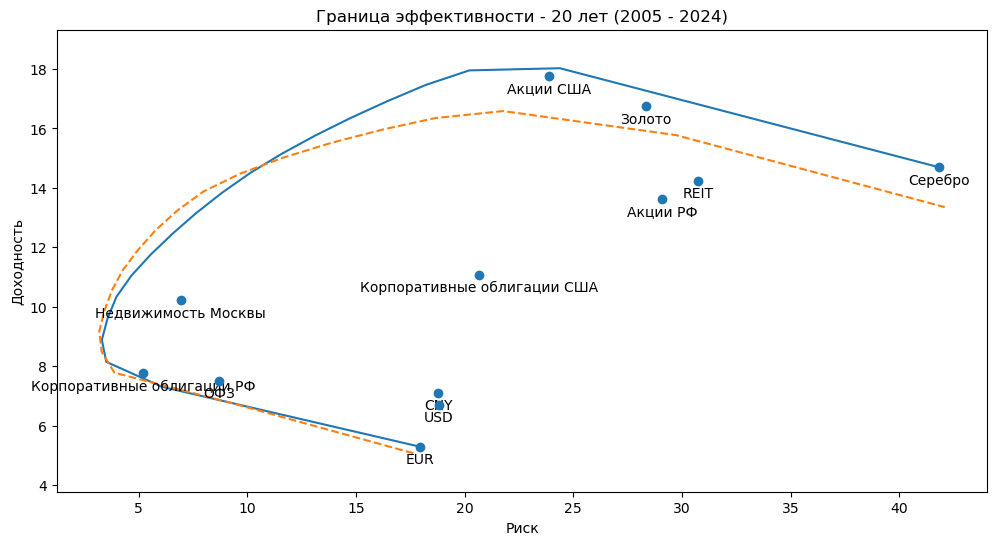

In [33]:
fig, ax = plt.subplots()

# Plotting the Efficient Frontier
ax.plot(df['Risk']*100, df['CAGR']*100)
ax.plot(df_last_y['Risk']*100, df_last_y['CAGR']*100, linestyle='dashed')

# Set X and Y labels
ax.set_xlabel('Риск')
ax.set_ylabel('Доходность')

ax.set_title("Граница эффективности - 20 лет (2005 - 2024)")

# Plotting the assets
x.plot_assets(kind='cagr', pct_values=True, tickers=list(short_names_2003.values()), xy_text=(0, -12))

## Корреляция классов

In [34]:
ls_classes = [
    'MCFTR.INDX',
    'RGBITR.INDX',
    'RUCBTRNS.INDX',
    'SP500TR.INDX',
    'GC.COMM',
]
 
lg_classes = [
    "ОФЗ",
    "Корпоративные облигации",
    "Акции США",
    "Золото"
]

In [35]:
cl = ok.AssetList(ls_classes, ccy='RUB', inflation=False)
cl

assets           [MCFTR.INDX, RGBITR.INDX, RUCBTRNS.INDX, SP500...
currency                                                       RUB
first_date                                                 2003-01
last_date                                                  2025-01
period_length                                   22 years, 1 months
inflation                                                     None
dtype: object

Text(0.5, 1.0, 'Долгосрочная корреляция между Индексом Мосбиржи и ОФЗ, Корпоративными облигациями РФ, Акциями США, золотом')

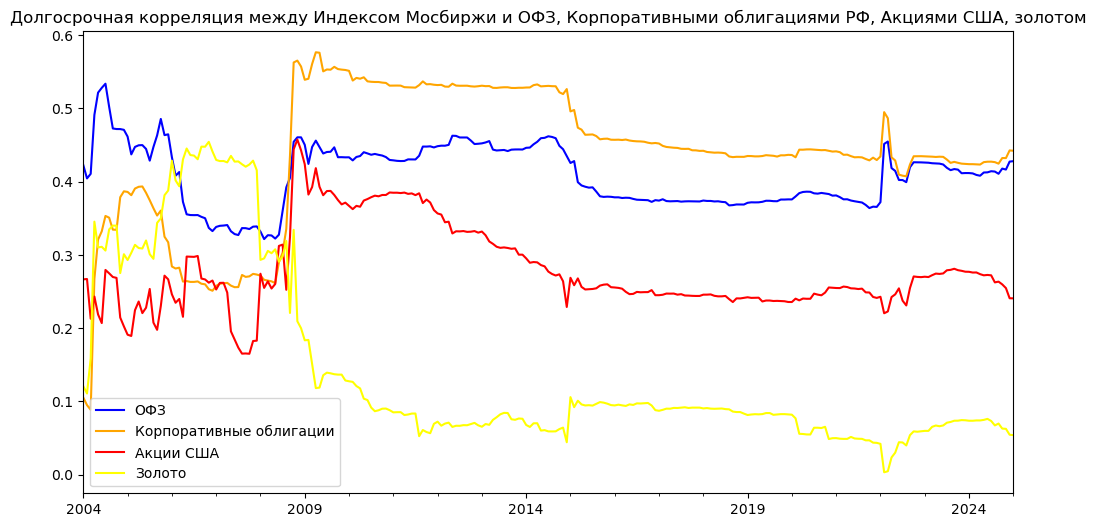

In [36]:
cl.index_corr().plot(color=["blue", "orange", "red", "yellow"])
plt.legend(lg_classes)
plt.xlabel("")
plt.title("Долгосрочная корреляция между Индексом Мосбиржи и ОФЗ, Корпоративными облигациями РФ, Акциями США, золотом")

Text(0.5, 1.0, 'Долгосрочная корреляция между Индексом Мосбиржи и другими активами. Скользящая 10 лет')

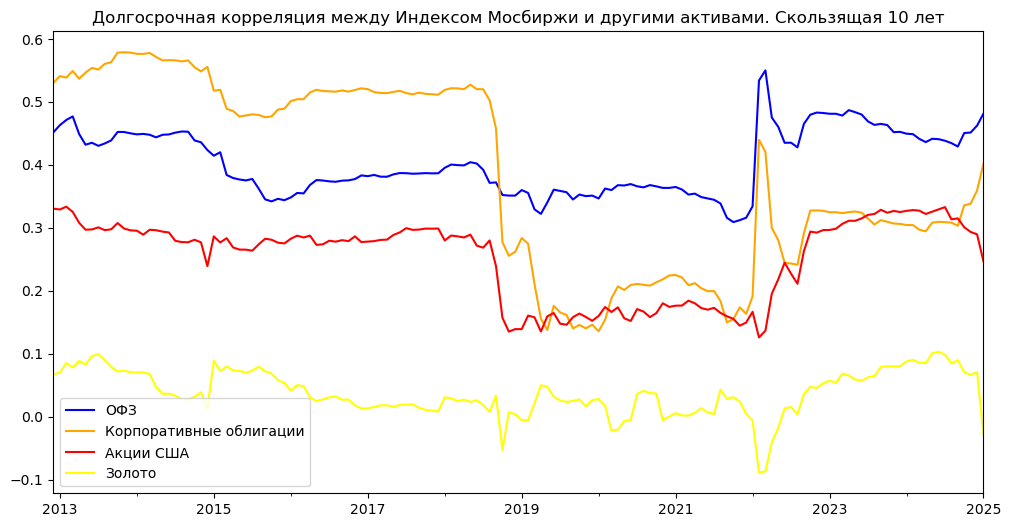

In [37]:
cl.index_corr(rolling_window=12*10).plot(color=["blue", "orange", "red", "yellow"])
plt.legend(lg_classes)
plt.xlabel("")
plt.title("Долгосрочная корреляция между Индексом Мосбиржи и другими активами. Скользящая 10 лет")

## Риск

In [101]:
risk_assets_us = {
    "VBMFX.US": "Облигации США",
    "SP500TR.INDX": "Акции США",
}

first_date_dt=Period('1998-01', 'M')


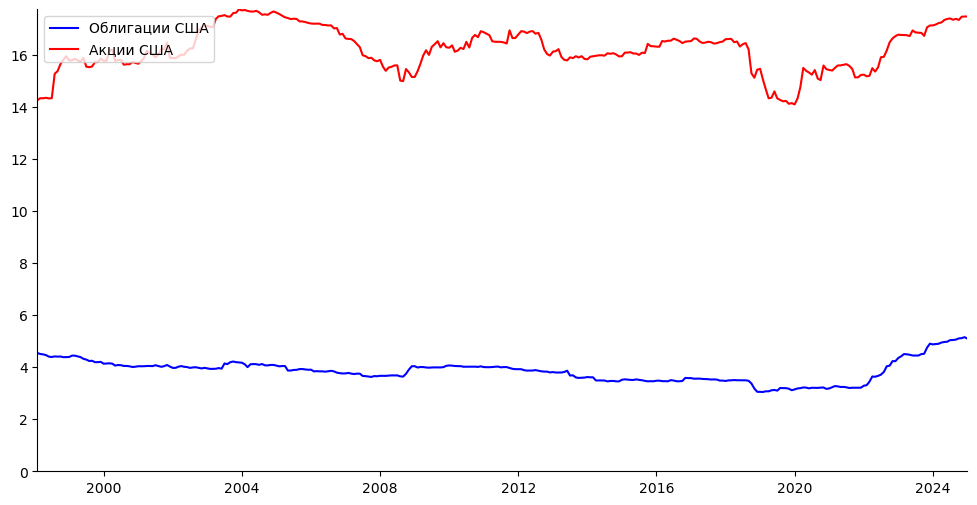

In [108]:
plot_rolling_cagr(assets_dict=risk_assets_us, ccy="USD", window=10*12, real=False, chart="risk")

In [102]:
risk_assets_ru = {
    "MCFTR.INDX": "Акции РФ",
    "RUCBTRNS.INDX": "Облигации РФ",
}

first_date_dt=Period('2012-12', 'M')


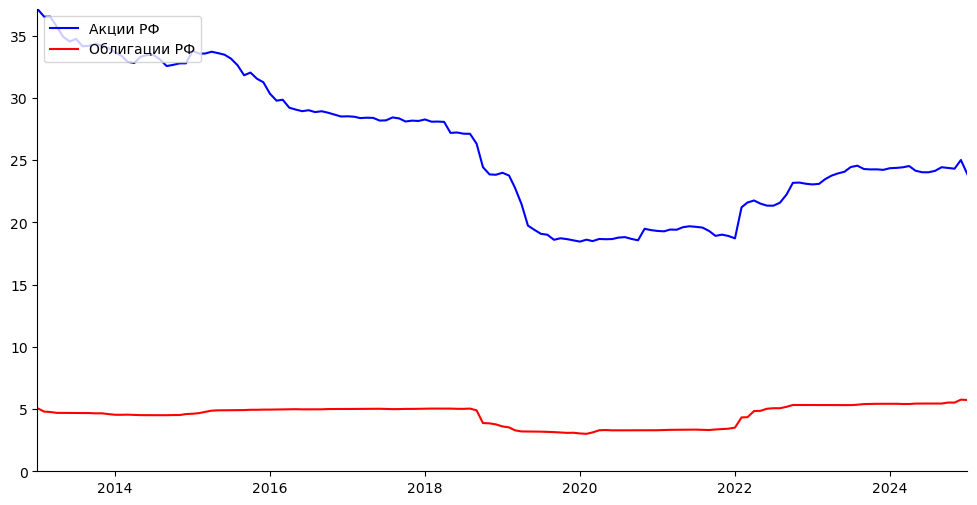

In [107]:
plot_rolling_cagr(assets_dict=risk_assets_ru, ccy="RUB", window=10*12, real=False, chart="risk")

## Скользящие

### Денежные фонды, облигации, депозиты

In [66]:
fix_return_dict = {
    'RUCBTRNS.INDX': "Корпоративные облигации - RUCBTRNS",
    'RUONIA.INDX': 'Фонды денежного рынка - RUONIA',
    'OKID.INDX': "Депозиты в рублях - OKID"
}

first_date_dt=Period('2012-06', 'M')


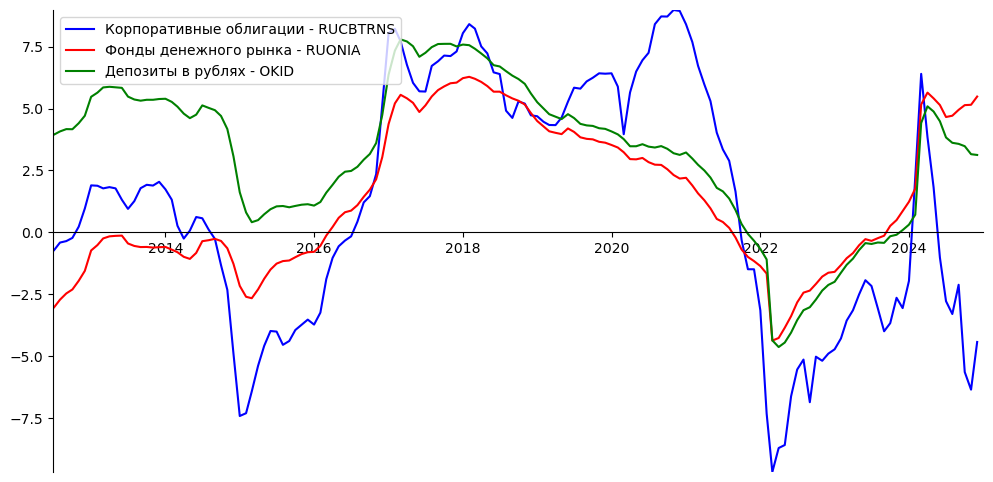

In [84]:
plot_rolling_cagr(assets_dict=fix_return_dict, ccy="RUB", window=2*12, real=True)

### ОФЗ и корпоративные облигации

In [28]:
obl = {
    'RGBITR.INDX': 'Облигации федерального займа - RGBI',
    'RUCBTRNS.INDX': 'Корпоративные облигации - RUCBTRNS'
}

first_date_dt=Period('2004-12', 'M')


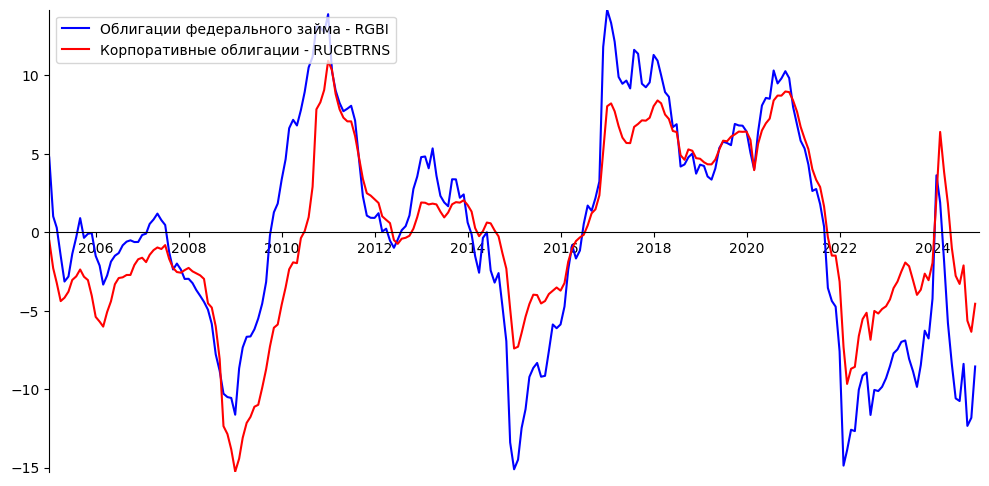

In [29]:
plot_rolling_cagr(assets_dict=obl, ccy="RUB", window=2*12, real=True)

### MOEX vs SP500

In [47]:
stocks = {
    'MCFTR.INDX': 'Индекс Московской биржи - MCFTR',
    'SP500TR.INDX': 'Индекс S&P500 - SP500TR'
}

first_date_dt=Period('1999-09', 'M')


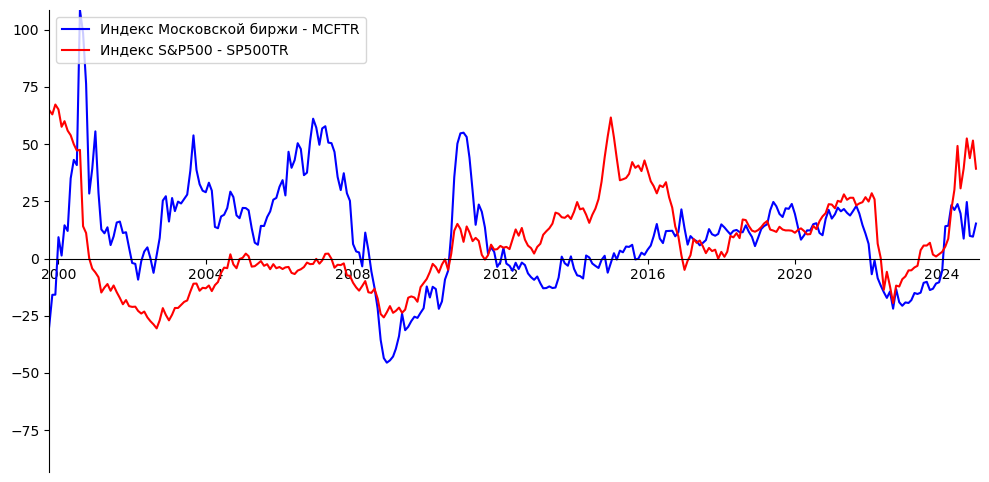

In [49]:
plot_rolling_cagr(assets_dict=stocks, ccy="RUB", window=2*12, real=True)

In [38]:
gld = {
    'GC.COMM': "Золото",
    'MCFTR.INDX': 'Индекс Московской биржи - MCFTR',
}

### Золото и акции России

first_date_dt=Period('1999-09', 'M')


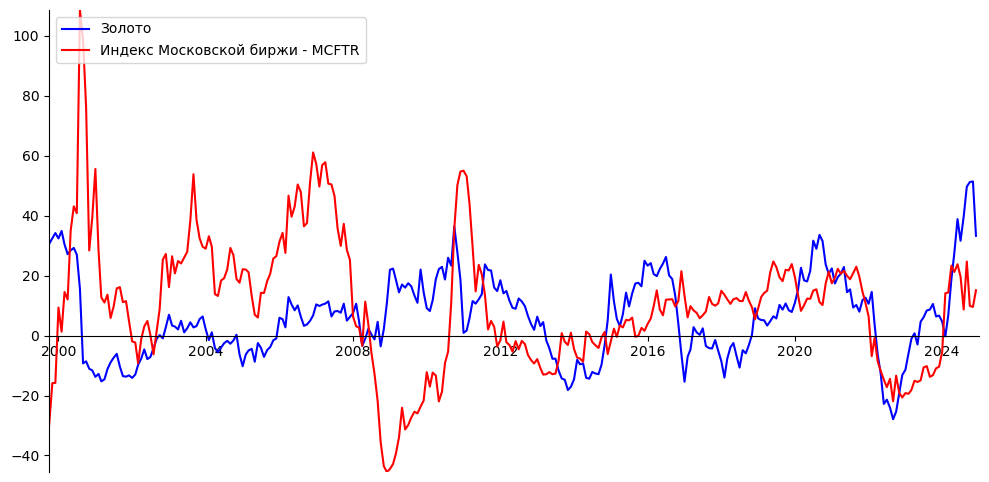

In [42]:
plot_rolling_cagr(assets_dict=gld, ccy="RUB", window=2*12, real=True)

first_date_dt=Period('2007-09', 'M')


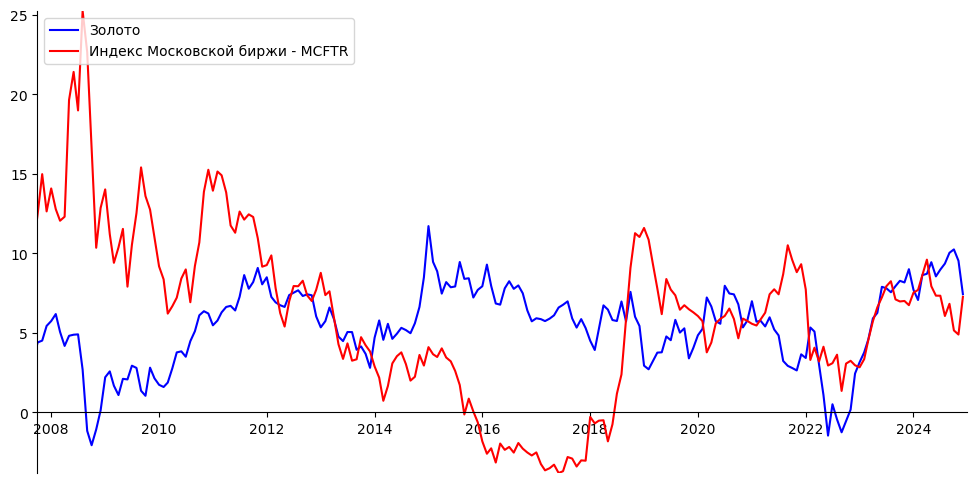

In [41]:
plot_rolling_cagr(assets_dict=gld, ccy="RUB", window=10*12, real=True)

### Доллар США

In [49]:
usd = {
    'USDRUB.FX': "Доллар США",
    # 'OKID.INDX': "Депозиты в рублях",
    # 'RUCBTRNS.INDX': "Корпоративные облигации"
}

first_date_dt=Period('2002-07', 'M')


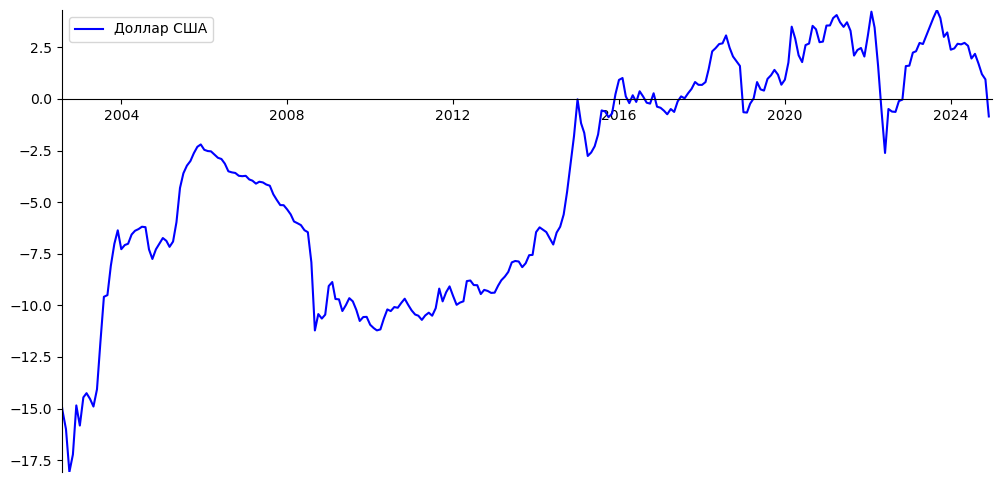

In [51]:
plot_rolling_cagr(assets_dict=usd, ccy="RUB", window=10*12, real=True)

### BTC

In [38]:
## BTC
btc = {
    'BTC-USD.CC': "Биткоин",
    # 'OKID.INDX': "Депозиты в рублях",
    # 'RUCBTRNS.INDX': "Корпоративные облигации"
}

first_date_dt=Period('2015-07', 'M')


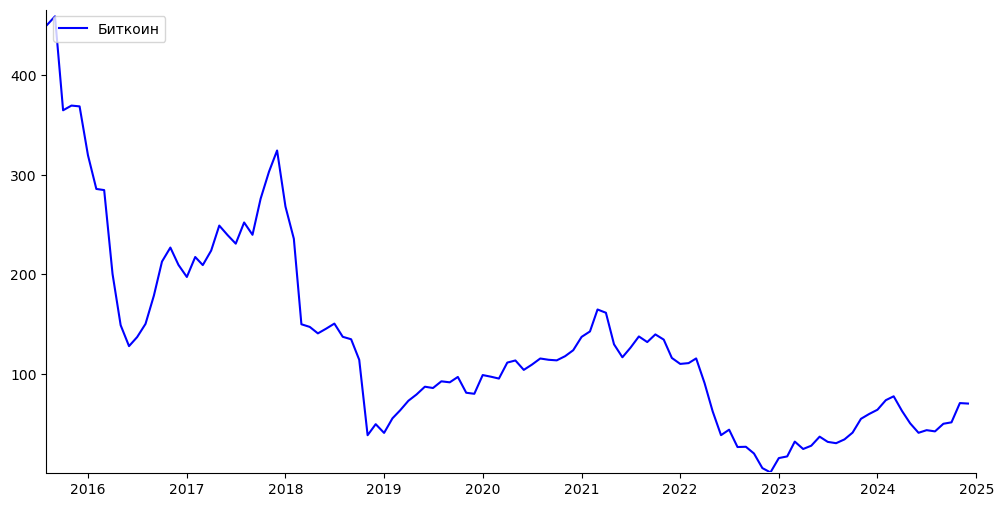

In [44]:
plot_rolling_cagr(assets_dict=btc, ccy="RUB", window=5*12, real=True)

## CAPE10

In [111]:
cape_symbols = ok.symbols_in_namespace('RATIO')['symbol']

In [112]:
cape_objects = [ok.Indicator(cape) for cape in cape_symbols]

In [113]:
len(cape_objects)

26

Text(0.5, 1.0, 'Циклический P/E Шиллера (CAPE10). Январь 2025')

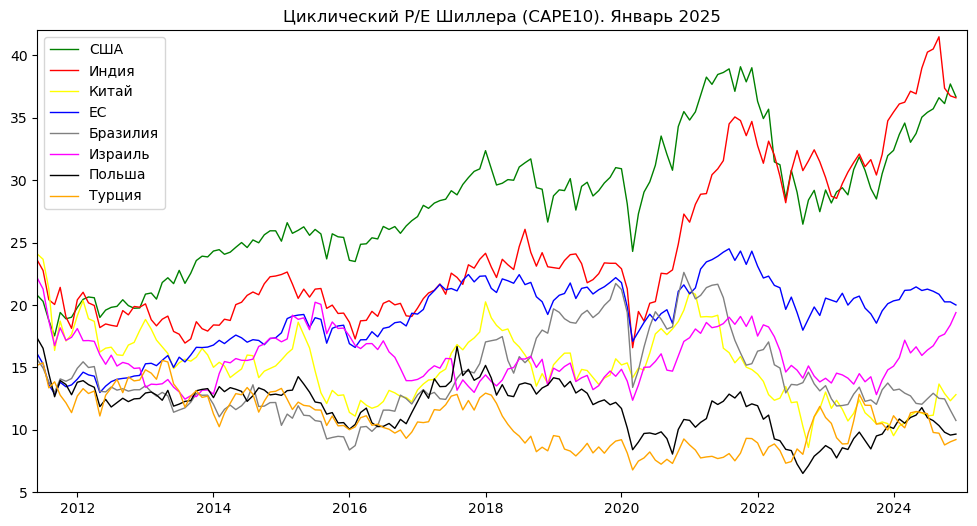

In [36]:
pl = ok.Indicator('POL_CAPE10.RATIO').values_monthly
tk = ok.Indicator('TUR_CAPE10.RATIO').values_monthly
chn = ok.Indicator('CHN_CAPE10.RATIO').values_monthly
# rus = ok.Indicator('RUS_CAPE10.RATIO').values_monthly
isr = ok.Indicator('ISR_CAPE10.RATIO').values_monthly
usa = ok.Indicator('USA_CAPE10.RATIO').values_monthly
ind = ok.Indicator('IND_CAPE10.RATIO').values_monthly
eur = ok.Indicator('EUR_CAPE10.RATIO').values_monthly
bra = ok.Indicator('BRA_CAPE10.RATIO').values_monthly


fig, ax = plt.subplots(figsize=[12, 6])
first_date_dt = pd.to_datetime('2011-06')  # дата начала графика
last_date_dt = pd.to_datetime('2025-01')  # дата конца

ax.plot(usa.index.to_timestamp(), usa, color ='green', linewidth = 1, label='США')
ax.plot(ind.index.to_timestamp(), ind, color ='red', linewidth = 1, label='Индия')
ax.plot(chn.index.to_timestamp(), chn, color ='yellow', linewidth = 1, label='Китай')
ax.plot(eur.index.to_timestamp(), eur, color ='blue', linewidth = 1, label='ЕС')
ax.plot(eur.index.to_timestamp(), bra, color ='gray', linewidth = 1, label='Бразилия')
ax.plot(eur.index.to_timestamp(), isr, color ='magenta', linewidth = 1, label='Израиль')
ax.plot(chn.index.to_timestamp(), pl, color ='black', linewidth = 1, label='Польша')
ax.plot(eur.index.to_timestamp(), tk, color ='orange', linewidth = 1, label='Турция')

ax.set_xlim(first_date_dt, last_date_dt + pd.DateOffset(months=1))   # прибавляем 1 месяц, чтобы в конце графика было пустое пространство
ax.set_ylim(5, 42)
ax.legend(loc='upper left')
ax.set_title('Циклический P/E Шиллера (CAPE10). Январь 2025')

In [114]:
cape_df = pd.DataFrame({cape.country: cape.values_monthly for cape in cape_objects})
print(cape_df["Russia"].tail(5))
cape_df.drop('Russia', axis=1, inplace=True)

date
2024-08    0.0
2024-09    0.0
2024-10    0.0
2024-11    0.0
2024-12    0.0
Freq: M, Name: Russia, dtype: float64


In [121]:
cape_df.iloc[-1].sort_values(ascending=False)

USA             36.68
India           36.59
Netherlands     32.24
Taiwan          31.12
Canada          24.63
Switzerland     23.77
Japan           23.71
France          23.07
Australia       22.26
Germany         21.49
Europe          20.00
Israel          19.39
Sweden          19.27
Italy           18.90
Singapore       17.56
South Africa    16.88
Mexico          16.49
Spain           16.02
UK              15.97
Hong Kong       13.55
China           12.82
Korea           11.98
Brazil          10.75
Poland           9.66
Turkey           9.22
Name: 2024-12, dtype: float64

In [120]:
cape_df.iloc[-1].sort_values().to_csv("cape10_2025.csv")

<Axes: xlabel='date'>

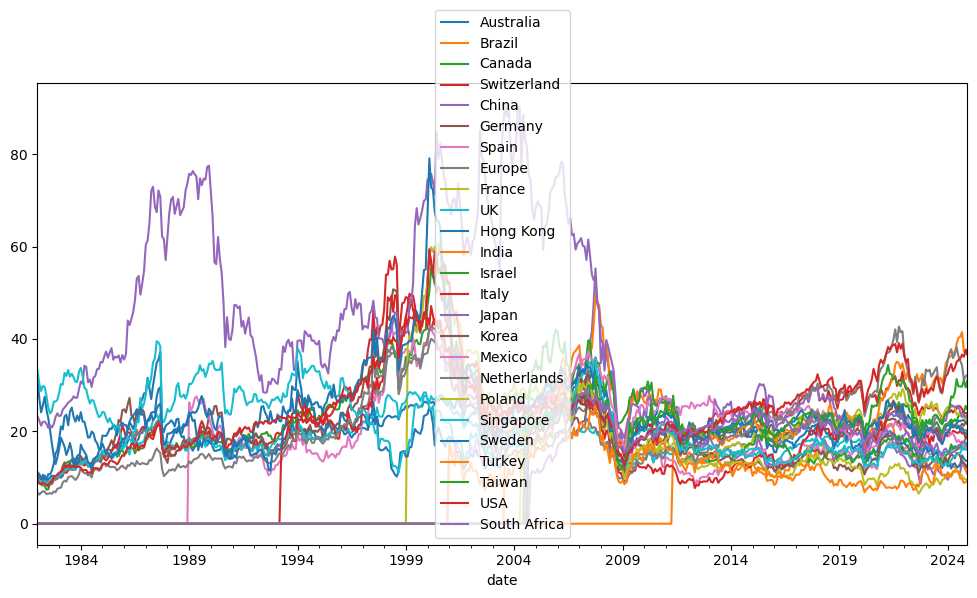

In [9]:
cape_df.plot(figsize=[12.0, 6.0])